In [4]:
import sys 
sys.path.append('..')

from copy import deepcopy
from pathlib import Path

import pandas as pd
import numpy as np

from IPython.display import display

import seaborn as sns

import matplotlib.pyplot as plt

import preprocessing.pt_cleaning as pt_cleaning

from preprocessing.external.feature_extraction import intercase_and_context
from preprocessing.grouping.clustering_pipelines import clust_kproto
from preprocessing.grouping.explainer import explainer_sklearn_dt
from preprocessing.external.predictive_monitoring_benchmark.experiments import BucketFactory

from preprocessing.external import config_data_from_file, Configuration, ReadOptions, LogReader



# Inter-case variability analysis

##### Parse Log

In [5]:
config_file = "./config/config_cons.yml"
GROUPED_OUTPUT_DF_NAME = './outputs/consulta_intercase_and_kproto_by_case'
UNGROUPED_OUTPUT_DF_NAME = './outputs/consulta_intercase_and_kproto'

pd.set_option('display.float_format', lambda x: '%.2f' % x)

config_path = Path(config_file)
config_data = config_data_from_file(config_path)
config = Configuration(**config_data)
options = ReadOptions(column_names=ReadOptions.column_names_default())

log = LogReader(config.log_path, options)

parsing log, completed traces :: 100%|██████████| 954/954 [00:00<00:00, 1252.57it/s]


[DONE]


##### Add inter-arrival features & clean processing times

In [6]:
try:
    # to skip parsing on notebook resets
    log_df = pd.read_pickle("./outputs/" + config_file.split("./config/")[1] + "_case_grouping_dump.pkl")

except: 
    enriched_log_df, res_analyzer = intercase_and_context.extract(log, _model_type='dual_inter')
    log_df = pt_cleaning.clean_processing_times_with_calendar(enriched_log_df, config, res_analyzer)

    log_df.to_pickle("./outputs/" + config_file.split("./config/")[1] + "_case_grouping_dump.pkl") 

log_df.head()

mining calendars:: 100%|██████████| 2/2 [00:16<00:00,  8.33s/it]


,caseid,task,user,end_timestamp,start_timestamp,Activity,Resource,@@startevent_concept:name,@@startevent_org:resource,@@startevent_Activity,...,st_month,end_daytime,end_weekday,end_month,Role,timetable_id,processing_time,waiting_time,started_offtimetable,ended_offtimetable
0,100101,Traer informacion estudiante - banner,7071,2016-03-13 00:59:55,2016-03-13 00:59:55,Traer informacion estudiante - banner,7071,Traer informacion estudiante - banner,7071,Traer informacion estudiante - banner,...,3,3595,6,3,Role 1,QBP_RES_ROLE_1_TIMETABLE,0.00,0.00,False,True
1,100101,Radicar Solicitud Homologacion,7071,2016-03-13 01:00:02,2016-03-13 01:00:02,Radicar Solicitud Homologacion,7071,Radicar Solicitud Homologacion,7071,Radicar Solicitud Homologacion,...,3,3602,6,3,Role 1,QBP_RES_ROLE_1_TIMETABLE,0.00,0.00,False,True
2,100101,Validar solicitud,22475,2016-03-13 01:19:56,2016-03-13 01:19:49,Validar solicitud,22475,Validar solicitud,22475,Validar solicitud,...,3,4796,6,3,Role 3,QBP_RES_ROLE_3_TIMETABLE,7.00,0.00,False,True
3,100101,Revisar curso,22475,2016-03-14 15:07:40,2016-03-14 15:07:40,Revisar curso,22475,Revisar curso,22475,Revisar curso,...,3,54460,0,3,Role 3,QBP_RES_ROLE_3_TIMETABLE,0.00,0.00,False,True
4,100101,Homologacion por grupo de cursos,22478,2016-03-14 15:15:32,2016-03-14 15:07:40,Homologacion por grupo de cursos,22478,Homologacion por grupo de cursos,22478,Homologacion por grupo de cursos,...,3,54932,0,3,Role 2,QBP_RES_ROLE_2_TIMETABLE,472.00,0.00,True,False


### Discover groups of cases

#### Clustering with K-Prototypes

- K-Modes extends K-Means to handle categorical data. [Source](https://github.com/nicodv/kmodes)

- K-Prototypes package has same api as sk-learn and allows mixing categorical & numerical features. 


In [7]:
df = deepcopy(log_df).drop(columns=['@@duration'])

# Clean up: exclude cols, drop NAN
excluded = ['@@duration', 'Activity', 'Resource', 'Role', '@@startevent_concept:name',
       '@@startevent_org:resource', '@@startevent_Activity',
       '@@startevent_Resource', 'n_role', 'role', 'n_task']#, 'elementId', 'timetable_id', 'resourceId']

df = df.drop(columns=excluded, errors='ignore').dropna()
df = df[df.columns.drop(list(df.filter(regex='@@startevent_')))]

# Categorical pre-proc
cat_cols = ['user', 'st_weekday', 'end_weekday', 'st_month', 'end_month', "started_offtimetable", "ended_offtimetable"]
df['user'] = df['user'].apply(str)

#cat_cols = list(filter(lambda c : c != 'task', cat_cols))
display(cat_cols)

# Numerical pre-proc
num_cols = list(df.select_dtypes(['number']).columns)

# Aggregation-encoding approach - Irene Teinemaa's PPM Benchmarking
num_aggregators = ['mean', 'max','min','sum', 'std']
duration_aggregators = ['sum']

case_aggregators = {
    #'@@duration': duration_aggregators, 
    'waiting_time': duration_aggregators, 
    'processing_time':duration_aggregators, 
    'user': lambda x: x.iloc[0], 
    'st_weekday': lambda x: x.iloc[0], 
    'end_weekday': lambda x: x.iloc[-1],
    'st_month': lambda x: x.iloc[0], 
    'end_month': lambda x: x.iloc[-1],
    "started_offtimetable": lambda x: x.iloc[0], # first item of the trace
	"ended_offtimetable": lambda x: x.iloc[-1], # last item of the trace
    "st_daytime": lambda x: x.iloc[0],
	"end_daytime": lambda x: x.iloc[-1]
}

for c in num_cols:
    if (c not in excluded) and (c not in case_aggregators.keys()):
        case_aggregators[c] = num_aggregators

by_case = df.sort_values(['start_timestamp'], ascending=True).groupby('caseid').agg(case_aggregators)

by_case = by_case.drop(columns=['end_timestamp', 'start_timestamp'], errors='ignore')


by_case.columns = [a[0] if (a[1] == "<lambda>") else "_".join(a) for a in by_case.columns.to_flat_index()] 

# update with aggregated cols
#num_cols = list(by_case.select_dtypes(['number']).columns)
cat_cols = list(set(cat_cols + list(by_case.select_dtypes(['object']).columns)))

categorical_indexes = [by_case.columns.get_loc(f"{c}") for c in cat_cols]
num_cols = by_case.columns[list(set(list(range(0, len(by_case.columns))))-set(categorical_indexes))]

by_case = by_case.dropna()

print(by_case.info())
by_case.head()

['user',
 'st_weekday',
 'end_weekday',
 'st_month',
 'end_month',
 'started_offtimetable',
 'ended_offtimetable']

<class 'pandas.core.frame.DataFrame'>
Index: 945 entries, 100101 to 99801
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   waiting_time_sum      945 non-null    float64
 1   processing_time_sum   945 non-null    float64
 2   user                  945 non-null    object 
 3   st_weekday            945 non-null    int64  
 4   end_weekday           945 non-null    int64  
 5   st_month              945 non-null    int64  
 6   end_month             945 non-null    int64  
 7   started_offtimetable  945 non-null    bool   
 8   ended_offtimetable    945 non-null    bool   
 9   st_daytime            945 non-null    int64  
 10  end_daytime           945 non-null    int64  
 11  st_wip_mean           945 non-null    float64
 12  st_wip_max            945 non-null    int64  
 13  st_wip_min            945 non-null    int64  
 14  st_wip_sum            945 non-null    int64  
 15  st_wip_std           

,waiting_time_sum,processing_time_sum,user,st_weekday,end_weekday,st_month,end_month,started_offtimetable,ended_offtimetable,st_daytime,...,rp_end_oc_mean,rp_end_oc_max,rp_end_oc_min,rp_end_oc_sum,rp_end_oc_std,daytime_mean,daytime_max,daytime_min,daytime_sum,daytime_std
caseid,,,,,,,,,,,,,,,,,,,,,
100101,0.00,950.00,7071,6,0,3,3,False,False,3595,...,0.01,0.05,0.00,0.06,0.02,0.00,0,0,0,0.00
100102,0.00,6457.00,7071,6,3,3,4,False,False,4848,...,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0.00
100952,0.00,43536.00,5641,0,4,3,6,False,False,62512,...,0.02,0.09,0.00,0.20,0.03,0.00,0,0,0,0.00
100953,0.00,36.00,7736,0,0,3,3,False,True,65083,...,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0.00
100954,0.00,16.00,7736,0,0,3,3,False,True,67361,...,0.01,0.03,0.00,0.03,0.01,0.00,0,0,0,0.00


Cost: 845.9996322296986


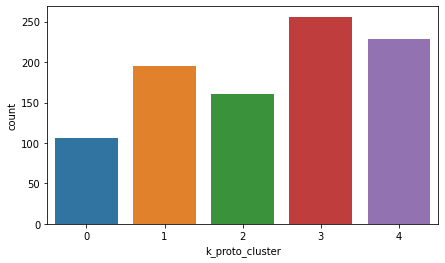

In [8]:
#known best k values
if config_file.split("./config/")[1] == "config_cons.yml":
    elbow = 5 # consulta
else:
    elbow=0

clusters, centers  = clust_kproto(by_case, categorical_indexes, num_cols, K_MODES_ELBOW=5) # elbow value 0 to force best k re-computation

by_case['k_proto_cluster'] = clusters
by_case.to_pickle(GROUPED_OUTPUT_DF_NAME)

log_df_with_case_cluster = pd.merge(log_df, by_case[['k_proto_cluster']], on="caseid")
log_df_with_case_cluster.to_pickle(UNGROUPED_OUTPUT_DF_NAME)

plt.subplots(figsize = (7, 4))
sns.countplot(x='k_proto_cluster', data = by_case)
plt.show()


#### Methods from Irene's PPM Benchmarking: K-Means clustering & Prefix-Length Buckets

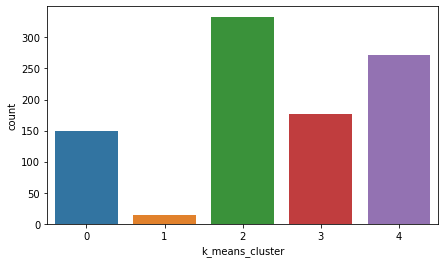

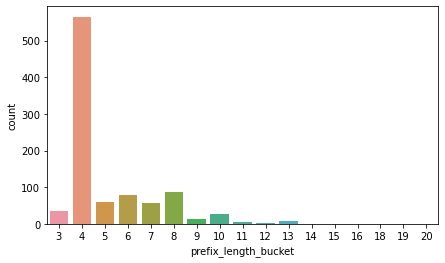

In [9]:
df = pd.read_pickle(UNGROUPED_OUTPUT_DF_NAME)
by_case = pd.read_pickle(GROUPED_OUTPUT_DF_NAME)

cat_cols = ['user', 'st_weekday', "end_weekday", 'st_month', "end_month", "started_offtimetable", "ended_offtimetable"]
num_cols = list(df.select_dtypes(['number']).columns)

# irene clusters
cluster_agg = BucketFactory.get_bucketer('cluster', n_clusters=5, encoding_method="agg", case_id_col="caseid", num_cols=num_cols, cat_cols=cat_cols)
clusters = cluster_agg.fit_predict(df)
by_case['k_means_cluster'] = clusters

plt.subplots(figsize = (7, 4))
sns.countplot(x='k_means_cluster', data = by_case)
plt.show()

# irene prefix-length buckets
bucketer = BucketFactory.get_bucketer(
        "prefix", case_id_col="caseid", num_cols=num_cols, cat_cols=cat_cols
    )
buckets = bucketer.fit_predict(df)
by_case["prefix_length_bucket"] = buckets

plt.subplots(figsize = (7, 4))
sns.countplot(x='prefix_length_bucket', data = by_case)
plt.show()

### Explain differences between  groups

#### By K-Prototypes Cluster


Grouping by k_proto_cluster

8 Decision Rules found:

if (st_wip_max > 223.0) and (st_wip_min > 176.0) and (st_daytime > 48440.5) then class = 3 | Prob: 87.85%, based on 288 samples
if (st_wip_max <= 223.0) and (end_wip_mean <= 150.75) and (end_month_6 <= 0.5) then class = 4 | Prob: 87.98%, based on 208 samples
if (st_wip_max > 223.0) and (st_wip_min > 176.0) and (st_daytime <= 48440.5) then class = 1 | Prob: 95.97%, based on 124 samples
if (st_wip_max <= 223.0) and (end_wip_mean <= 150.75) and (end_month_6 > 0.5) then class = 0 | Prob: 66.97%, based on 109 samples
if (st_wip_max <= 223.0) and (end_wip_mean > 150.75) and (st_daytime > 50030.5) then class = 0 | Prob: 98.82%, based on 85 samples
if (st_wip_max > 223.0) and (st_wip_min <= 176.0) and (end_wip_max > 267.0) then class = 2 | Prob: 100.0%, based on 82 samples
if (st_wip_max <= 223.0) and (end_wip_mean > 150.75) and (st_daytime <= 50030.5) then class = 1 | Prob: 40.0%, based on 30 samples
if (st_wip_max > 223.0) and (st_wip_mi

processing_time_sum                                           \
                              count     mean      std  min      25%      50%   
k_proto_cluster                                                                
0                            106.00 29459.14 21000.00 0.00 11180.50 27222.50   
1                            195.00  5472.51 11461.52 0.00   146.50   969.00   
2                            160.00  6998.57  8439.18 0.00   703.00  4110.50   
3                            256.00  6753.49  8135.32 0.00   557.00  3780.50   
4                            228.00  6509.12 12147.30 0.00   290.50  1849.00   

                                   waiting_time_sum                           \
                     75%       max            count   mean     std  min  25%   
k_proto_cluster                                                                
0               43295.75 104606.00           106.00 686.60 2560.48 0.00 0.00   
1                5241.00  99812.00           195.00  18.77  262.10 0.00 0.00   
2                9387.00  48439.00           160.00 160.12  750.96 0.00 0.00   
3                9177.25  47188.00           256.00  14.30  228.75 0.00 0.00   
4                7080.00  88665.00           228.00 127.89 1264.68 0.00 0.00   

                                    
                 50%  75%      max  
k_proto_cluster                     
0               0.00 0.00 18120.00  
1               0.00 0.00  3660.00  
2               0.00 0.00  3660.00  
3               0.00 0.00  3660.00  
4               0.00 0.00 18060.00

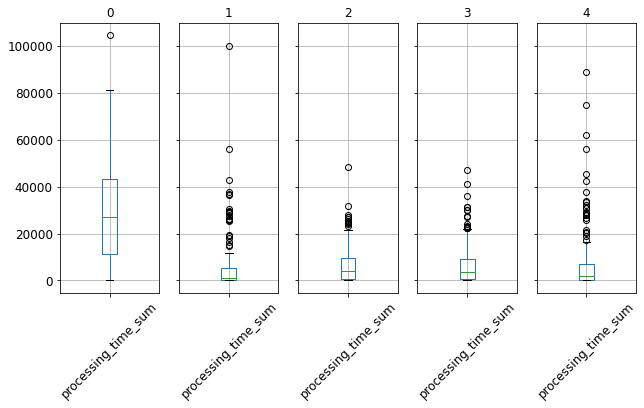

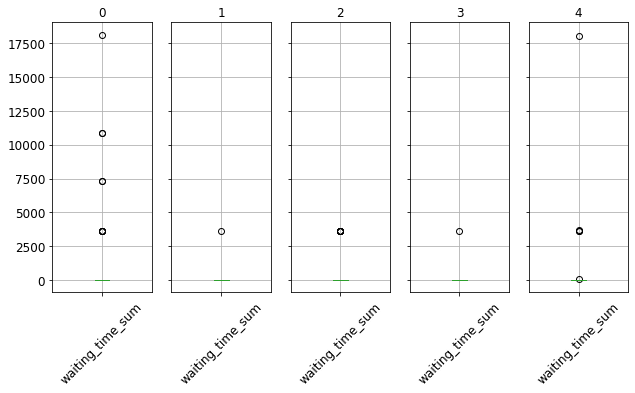

In [10]:
# One-hot encoding necessary because sk-learn dec. tree classifier does not handle categorical vars.
for c in cat_cols:
    by_case[c] = by_case[c].apply(str)
one_hot_data = pd.get_dummies(by_case[cat_cols],drop_first=True)
enc_by_case_df = pd.merge(by_case.drop(columns=cat_cols), one_hot_data, left_index=True, right_index=True)

clf, rule_printer, path_visualizer, top_feature_getter, duration_stats_getter = explainer_sklearn_dt(enc_by_case_df, "k_proto_cluster", max_depth=3, min_samples_leaf=1, min_samples_split=0.10, exclude=['k_means_cluster', 'prefix_length_bucket', 'processing_time_sum', 'waiting_time_sum'])

rule_printer()

stats = duration_stats_getter(_figsize=(10, 5))
stats.describe()

##### Visualizing decision path of particular cases

In [11]:
try:
    cases = []
    for cluster in np.unique(enc_by_case_df.k_proto_cluster):
        case = enc_by_case_df[enc_by_case_df.k_proto_cluster == cluster].sample().iloc[0]
        cases.append(case)
        path_visualizer(case)

    # To print the particular cases in a table, displaying the most important features of the decision tree + labels by different methods
    pd.DataFrame(cases)[top_feature_getter(5)+['k_proto_cluster','k_means_cluster', 'prefix_length_bucket']]
except:
    pass


Case class: 0.0
Reasons:
223.0 <= st_wip_max 
st_wip_min < 176.0
end_wip_max < 267.0


Case class: 1.0
Reasons:
st_daytime < 48440.5
223.0 <= st_wip_max 
176.0 <= st_wip_min 


Case class: 2.0
Reasons:
st_daytime < 48440.5
223.0 <= st_wip_max 
176.0 <= st_wip_min 


Case class: 3.0
Reasons:
st_daytime < 48440.5
223.0 <= st_wip_max 
176.0 <= st_wip_min 


Case class: 4.0
Reasons:
223.0 <= st_wip_max 
st_wip_min < 176.0
end_wip_max < 267.0



#### By K-Means Cluster


In [12]:
_, rule_printer_km, _, _, duration_stats_getter_km = explainer_sklearn_dt(enc_by_case_df, "k_means_cluster", max_depth=5, min_samples_leaf=1, min_samples_split=0.2, exclude=['k_proto_cluster', 'prefix_length_bucket'])


Grouping by k_means_cluster

8 Decision Rules found:

if (st_daytime > 37450.5) and (st_wip_sum <= 1549.0) and (st_daytime > 63058.5) and (end_daytime > 19270.5) and (rp_st_oc_sum <= 0.084) then class = 0 | Prob: 73.46%, based on 211 samples
if (st_daytime > 37450.5) and (st_wip_sum <= 1549.0) and (st_daytime <= 63058.5) and (end_daytime > 13010.5) then class = 1 | Prob: 72.68%, based on 183 samples
if (st_daytime > 37450.5) and (st_wip_sum > 1549.0) then class = 4 | Prob: 71.97%, based on 157 samples
if (st_daytime <= 37450.5) and (rp_st_oc_sum <= 0.153) then class = 2 | Prob: 88.67%, based on 150 samples
if (st_daytime > 37450.5) and (st_wip_sum <= 1549.0) and (st_daytime > 63058.5) and (end_daytime > 19270.5) and (rp_st_oc_sum > 0.084) then class = 0 | Prob: 75.0%, based on 112 samples
if (st_daytime <= 37450.5) and (rp_st_oc_sum > 0.153) then class = 1 | Prob: 37.5%, based on 56 samples
if (st_daytime > 37450.5) and (st_wip_sum <= 1549.0) and (st_daytime > 63058.5) and (end_daytim

processing_time_sum                                      \
                              count     mean      std      min      25%   
k_means_cluster                                                           
0                            150.00 18706.17 16857.85    89.00  6417.00   
1                             15.00 49169.87 31844.97 11388.00 23825.50   
2                            333.00  8042.21 12269.90     0.00   429.00   
3                            176.00  5782.49  8802.59     0.00   270.50   
4                            271.00  4735.45  8199.71     0.00   238.50   

                                            waiting_time_sum                  \
                     50%      75%       max            count    mean     std   
k_means_cluster                                                                
0               13906.00 27709.25  81130.00           150.00  242.40 1372.42   
1               42575.00 73387.00 104606.00            15.00 1696.00 4720.62   
2                2880.00  9744.00  74825.00           333.00  142.16 1202.63   
3                2300.00  7754.75  48439.00           176.00   83.52  546.98   
4                1445.00  6218.00  88665.00           271.00   40.74  385.76   

                                              
                 min  25%  50%  75%      max  
k_means_cluster                               
0               0.00 0.00 0.00 0.00 10860.00  
1               0.00 0.00 0.00 0.00 18120.00  
2               0.00 0.00 0.00 0.00 18060.00  
3               0.00 0.00 0.00 0.00  3660.00  
4               0.00 0.00 0.00 0.00  3720.00

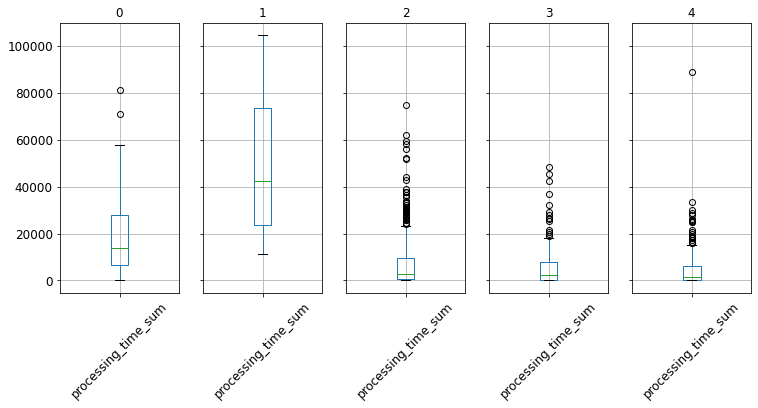

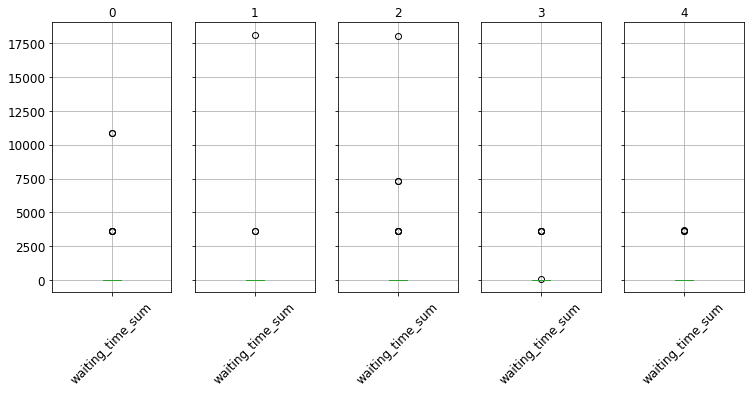

In [13]:
rule_printer_km()

stats_km = duration_stats_getter_km(_figsize=(12, 5))
stats_km.describe()

#### By Prefix-Length Bucket

In [14]:
#_, rule_printer_pb, _, _, duration_stats_getter_pb  = explainer_sklearn_dt(enc_by_case_df, "prefix_length_bucket", max_depth=3, exclude=['k_means_cluster', 'k_proto_cluster'])

In [15]:
#rule_printer_pb()

#stats_pb = duration_stats_getter_pb(_figsize=(20, 5))
#stats_pb.describe()

In [16]:
# TODO: analyze case clusters 0 and 2